In [1]:
import ranking_and_selection as rs
import queueing_model as qm
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical_high_N.json') as json_file:
    data_as_is_analytical_high_N = json.load(json_file)

# Opening JSON file
with open('data_10yr.json') as json_file:
    data_10yr = json.load(json_file)    

In [3]:
# Explore range of shelter costs and service time distributions
# print('start at time ' + str(datetime.datetime.now()))

b = 12 # baseline amount of house builds
hx = 60 # baseline extra house units
s = 12 # baseline amount of shelters to add you can get for the price of 12 housing

yrs_dec = 4 # decision space years

additional_shelter = [hx + 36]
service_times = [2]

housing_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1 = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_qu_unsh_vs_t = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_qu_unsh_vs_t = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_qu_sh_vs_t = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_qu_sh_vs_t = [[] for i in range(len(additional_shelter))]
housing_imprv_all4_obj1_p_q = [[] for i in range(len(additional_shelter))]
shelter_imprv_all4_obj1_p_q = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    sx = additional_shelter[i]
    for j in range(len(service_times)):
        sols = [{'housing': [b+hx, b, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b+hx, b, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b+hx, b], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b+hx], 'shelter': [s, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s+sx, s, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s+sx, s, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s+sx, s]},
                {'housing': [b, b, b, b], 'shelter': [s, s, s, s+sx]}]
        # expand solution space
        sols = [{'housing' : sols[k]['housing']+[b for l in range(data_10yr['analysis_horizon'] - yrs_dec)],
                 'shelter' : sols[k]['shelter']+[s for l in range(data_10yr['analysis_horizon'] - yrs_dec)]} for k in range(len(sols))]
        spc = rs.SolutionSpace(sols)
        spc.model_analytically(data_10yr, data_as_is_analytical_high_N, data_10yr['analysis_horizon'], float(service_times[j]))
        
        housing_imprv1 = []
        shelter_imprv1 = []
        q_unsh_for_shelter_sols = []
        q_unsh_for_housing_sols = []
        q_sh_for_shelter_sols = []
        q_sh_for_housing_sols = []
        p_q_for_housing_sols = []
        p_q_for_shelter_sols = []
        
        for k in range(yrs_dec):
            # Data on avg unsheltered queue over duration of model run
            imprv = spc.true_outputs_unsh[k]
            housing_imprv1.append(imprv)
            imprv = spc.true_outputs_unsh[k+4]
            shelter_imprv1.append(imprv)

            # Data on unsheltered queue over time for model run
            q = spc.true_outputs_unsh_vs_t[k]
            q_unsh_for_housing_sols.append(q)
            q = spc.true_outputs_unsh_vs_t[k+4]
            q_unsh_for_shelter_sols.append(q)

            # Data on sheltered queue over time for model run
            q = spc.true_outputs_sh_vs_t[k]
            q_sh_for_housing_sols.append(q)
            q = spc.true_outputs_sh_vs_t[k+4]
            q_sh_for_shelter_sols.append(q)

            # Data on probabilities (number in queue)
            p = spc.true_probs_num_q[k]
            p_q_for_housing_sols.append(p)
            p = spc.true_probs_num_q[k+4]
            p_q_for_shelter_sols.append(p)
            
        housing_imprv_all4_obj1[i].append(housing_imprv1)
        shelter_imprv_all4_obj1[i].append(shelter_imprv1)
        housing_imprv_all4_obj1_qu_unsh_vs_t[i].append(q_unsh_for_housing_sols)
        shelter_imprv_all4_obj1_qu_unsh_vs_t[i].append(q_unsh_for_shelter_sols)
        housing_imprv_all4_obj1_qu_sh_vs_t[i].append(q_sh_for_housing_sols)
        shelter_imprv_all4_obj1_qu_sh_vs_t[i].append(q_sh_for_shelter_sols)
        housing_imprv_all4_obj1_p_q[i].append(p_q_for_housing_sols)
        shelter_imprv_all4_obj1_p_q[i].append(p_q_for_shelter_sols)
        
        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

done (0, 0) at time 2024-01-16 10:48:22.511792


#### Visualise objective value of time for given solutions

In [19]:
# Calculate percentiles
def get_percentiles(decision_yr, T, percentiles, data, i, j):
    """
    Parameters
    ----------
    decision_yr : int - year at which additional accomm built
    T : int - time duration to analyse in days
    percentiles : dict(int) - two percentiles (one high and one low) must be of form {'low': int, 'high' : int}
    data : list - data on probabilities
    i : int - index in list of possible 'additional shelter' values to analyse
    j : int - index in list of possible housing 'service times' values to analyse
    
    Returns
    -------
    out : dict(list) - percentiles of data in question
    """
    percentiles_high = [t for t in range(T)]
    percentiles_low = [t for t in range(T)]

    for t in range(T):
        looking_high = True
        looking_low = True
        n = 0
        prob_cumulative = 0
        while looking_high:
            prob_cumulative += data[i][j][decision_yr][n][t]
            if prob_cumulative > percentiles['low']:
                if looking_low == True:
                    percentiles_low[t] = n
                    looking_low = False
            if prob_cumulative > percentiles['high']:
                percentiles_high[t] = n
                looking_high = False
            n += 1

    out = {'low' : percentiles_low, 'high' : percentiles_high}
    return out

In [21]:
housing_percentiles = []
shelter_percentiles = []
for yr in range(yrs_dec):
    housing_percentiles.append(get_percentiles(yr, data_10yr['analysis_horizon']*365, {'low' : 0.1, 'high' : 0.9}, housing_imprv_all4_obj1_p_q, 0, 0))
    shelter_percentiles.append(get_percentiles(yr, data_10yr['analysis_horizon']*365, {'low' : 0.1, 'high' : 0.9}, shelter_imprv_all4_obj1_p_q, 0, 0))

In [33]:
2**16

65536

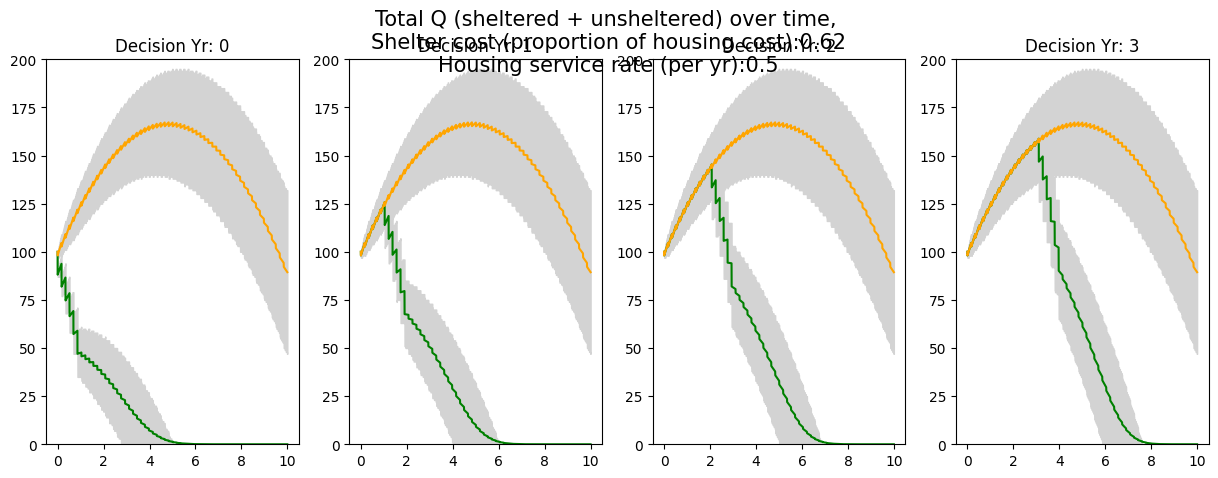

In [38]:
title1 = 'Shelter cost (proportion of housing cost):'
title2 = 'Housing service rate (per yr):'
n_cl = yrs_dec
n_rw = 1
fig, axs = plt.subplots(n_rw, n_cl, figsize=(15, 5), sharex=True)
x = [i/365 for i in range(3650)]
for yr in range(n_cl):
    y1 = [housing_imprv_all4_obj1_qu_unsh_vs_t[0][0][yr][i] + housing_imprv_all4_obj1_qu_sh_vs_t[0][0][yr][i] for i in range(3650)]
    y2 = [shelter_imprv_all4_obj1_qu_unsh_vs_t[0][0][yr][i] + shelter_imprv_all4_obj1_qu_sh_vs_t[0][0][yr][i] for i in range(3650)]
    line1, = axs[yr].plot(x, y1, color = 'green', label = 'extra housing')
    line2, = axs[yr].plot(x, y2, color = 'orange', label = 'extra housing')
    axs[yr].fill_between(x, housing_percentiles[yr]['low'], housing_percentiles[yr]['high'], color = 'lightgrey')
    axs[yr].fill_between(x, shelter_percentiles[yr]['low'], shelter_percentiles[yr]['high'], color = 'lightgrey')                        
    axs[yr].set_title('Decision Yr: ' + str(yr))
    axs[yr].set_ylim(0,200)
                        
plt.suptitle('Total Q (sheltered + unsheltered) over time, \n' + 
          title1 + 
          str(round(hx/additional_shelter[0],2)) + 
          '\n' + 
          title2 + 
          str(round(1/service_times[0],2)),fontsize = 15)
                        
# plt.xlabel('t (yrs)')
# plt.ylabel('Obj value: E[# Unsheltered + # Sheltered]')
# plt.ylim(0,500)
# plt.legend(loc = 'center right')
plt.show()

In [ ]:
title = 'Svc-rate: '
title2 = 'Shelter cost: '
x = [1,2,3,4]
n_cl = len(service_times)
n_rw = 1
fig, axs = plt.subplots(n_rw, n_cl, figsize=(8, 3), sharex=True)
for j in range(n_cl):
    line1, = axs[j].plot(x, housing_imprv_all3_obj1[0][j], color = 'green', label = 'extra housing', marker='o', markersize = 4)
    line2, = axs[j].plot(x, shelter_imprv_all3_obj1[0][j], color = 'orange', label = 'extra shelter', marker='o', markersize = 4)
    axs[j].set_title(title + '\n' + str(round(1/service_times[j],2)))
    axs[j].set_ylim(0,240)
    if j == 3:
        axs[j].set_xlabel("Year in which we decide to build extra capacity", loc = 'center')

plt.suptitle('Objective value vs. \n when we build extra accomm, \n' + title2 + 
             str(round(hx/additional_shelter[0],2)),fontsize = 15)
fig.legend(handles=[line1, line2], bbox_to_anchor=(1.1,0.5), loc = 'center') 
fig.tight_layout()

plt.text(-40, 430, 'Figure 3')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
#plt.xlabel("Year in which we decide to build extra capacity", loc = 'right')
plt.ylabel("Obj value: E[# Unsheltered]")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()